In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install spectral

In [4]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, ZeroPadding3D, Activation, AveragePooling3D, MaxPooling3D, GlobalMaxPooling2D, Add, GlobalAveragePooling3D
from keras.models import Model
from keras.models import Sequential
from keras import models
from keras import layers
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.initializers import glorot_uniform

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from spectral import spy_colors
import scipy.io as sio
import os
import spectral
import time
init_notebook_mode(connected=True)
%matplotlib inline

In [5]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.3
windowSize = 25

In [6]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [7]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [8]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [9]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [11]:
# data Loading
XX, y = loadData(dataset)
XX= ((XX-np.mean(XX))/np.std(XX))
# print(XX)
XX.shape, y.shape

((145, 145, 200), (145, 145))

In [12]:
K = XX.shape[2]
XX.shape[2]

200

In [13]:
K = 30 if dataset == 'IP' else 15
XX,pca = applyPCA(XX,numComponents=K)

XX.shape

(145, 145, 30)

In [14]:
XX, y = createImageCubes(XX, y, windowSize=windowSize)

XX.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [15]:
# Training and testing patches spitining
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(XX, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7174, 25, 25, 30), (3075, 25, 25, 30), (7174,), (3075,))

In [16]:
#train data reshape
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(7174, 25, 25, 30, 1)

In [17]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(7174, 16)

In [18]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [19]:
def Nopooling(input_shape=(S,S,L,1)):
  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)
  x=X_input
  # Stage 1
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(x)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
  conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
  ## Faltten 3D Convolutional Layer
  flatten_layer = Flatten()(conv_layer4)
  dense_layer2 = Dense(units=128, activation='relu')(flatten_layer)
  output_layer = Dense(units=16, activation='softmax')(dense_layer2)

  # # define the model with input layer and output layer
  model = Model(inputs = X_input, outputs = output_layer, name='3DCNN')
  

  return model

In [20]:
model=Nopooling(input_shape=(S,S,L,1))
model.summary()

Model: "3DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 30, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 17, 17, 16, 64)    55360     
_________________________________________________________________
flatten (Flatten)            (None, 295936)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               378799

In [21]:
# checkpoint
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/3DCNN/best-model.hdf5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
# model= ResNet18(input_shape=(S,S,L,1), classes=16)
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
start = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

end = time.time()
cnn_mnist_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_mnist_time/60.0))

Epoch 1/100
29/29 [==============================] - 13s 199ms/step - loss: 4.8859 - accuracy: 0.2364

Epoch 00001: accuracy improved from -inf to 0.34750, saving model to /content/drive/MyDrive/Colab Notebooks/3DCNN/best-model.hdf5
Epoch 2/100
29/29 [==============================] - 6s 196ms/step - loss: 0.6004 - accuracy: 0.8290

Epoch 00002: accuracy improved from 0.34750 to 0.89922, saving model to /content/drive/MyDrive/Colab Notebooks/3DCNN/best-model.hdf5
Epoch 3/100
29/29 [==============================] - 6s 196ms/step - loss: 0.0361 - accuracy: 0.9910

Epoch 00003: accuracy improved from 0.89922 to 0.99401, saving model to /content/drive/MyDrive/Colab Notebooks/3DCNN/best-model.hdf5
Epoch 4/100
29/29 [==============================] - 6s 196ms/step - loss: 0.0157 - accuracy: 0.9962

Epoch 00004: accuracy improved from 0.99401 to 0.99749, saving model to /content/drive/MyDrive/Colab Notebooks/3DCNN/best-model.hdf5
Epoch 5/100
29/29 [==============================] - 6s 196ms/

In [ ]:
# tf.keras.backend.clear_session()

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)

# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.experimental.TPUStrategy(resolver)

# with strategy.scope():
#   model= Nopooling(input_shape=(S,S,L,1), classes=16)
#   # compiling the model
#   adam = Adam(lr=0.001, decay=1e-06)
#   model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#   start = time.time()

#   history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=300, callbacks=callbacks_list)

#   end = time.time()
#   cnn_mnist_time = end-start
#   print("Total training time is {:0.2f} minute".format(cnn_mnist_time/60.0))

In [23]:
# load best weights
model.load_weights("/content/drive/MyDrive/Colab Notebooks/3DCNN/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

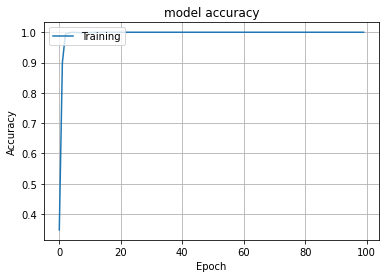

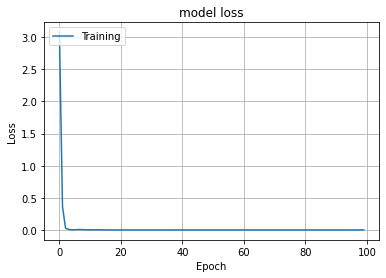

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Training'], loc='upper left') 
plt.savefig("/content/drive/MyDrive/Colab Notebooks/3DCNN/model_accuracy_100.svg")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Training'], loc='upper left') 
plt.savefig("/content/drive/MyDrive/Colab Notebooks/3DCNN/model_loss_100.svg")
plt.show()

In [25]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(3075, 25, 25, 30, 1)

In [26]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(3075, 16)

In [27]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00       428
           2       1.00      1.00      1.00       249
           3       1.00      1.00      1.00        71
           4       1.00      1.00      1.00       145
           5       1.00      1.00      1.00       219
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00       143
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00       292
          10       1.00      1.00      1.00       737
          11       0.99      1.00      1.00       178
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00       380
          14       1.00      0.99      1.00       116
          15       1.00      0.96      0.98        28

    accuracy                           1.00      3075
   macro avg       1.00   

In [28]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [29]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [30]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/Colab Notebooks/3DCNN/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

97/97 [==============================] - 1s 12ms/step - loss: 0.0018 - accuracy: 0.9989


In [31]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [32]:
# load the original image
XX, y = loadData(dataset)

In [33]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [34]:
XX,pca = applyPCA(XX, numComponents=numComponents)

In [35]:
XX = padWithZeros(XX, PATCH_SIZE//2)

In [36]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(XX,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

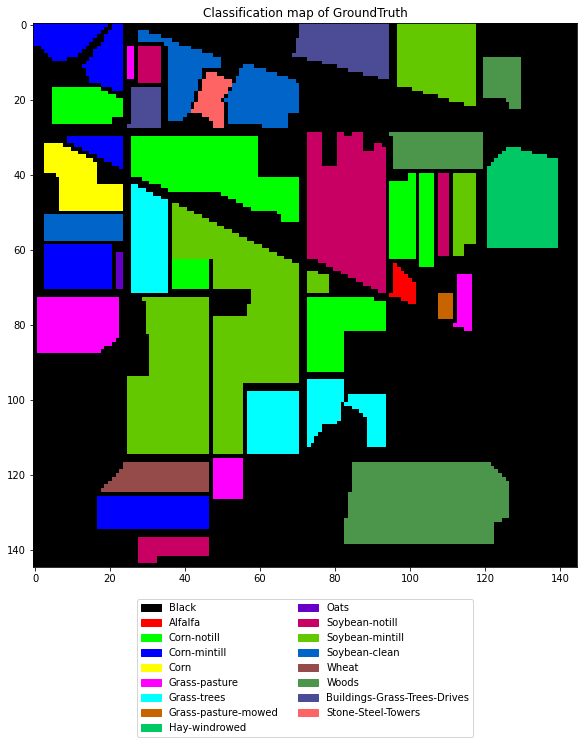

In [37]:
ground_truth = spectral.imshow(classes = y,figsize =(10,10))
plt.title('Classification map of GroundTruth')

if dataset == 'IP':
  labelDictionary= {1:'Alfalfa', 2:'Corn-notill', 3:'Corn-mintill', 4:'Corn',
                    5:'Grass-pasture', 6:'Grass-trees', 7:'Grass-pasture-mowed', 
                    8:'Hay-windrowed', 9:'Oats', 10:'Soybean-notill', 11:'Soybean-mintill',
                    12:'Soybean-clean', 13:'Wheat', 14:'Woods', 15:'Buildings-Grass-Trees-Drives',
                    16:'Stone-Steel-Towers', 0:'Black'}
elif dataset == 'SA':
  labelDictionary = {1:'Brocoli_green_weeds_1', 2:'Brocoli_green_weeds_2', 3:'Fallow', 4:'Fallow_rough_plow', 5:'Fallow_smooth',
                     6:'Stubble', 7:'Celery', 8:'Grapes_untrained', 9:'Soil_vinyard_develop', 10:'Corn_senesced_green_weeds',
                    11:'Lettuce_romaine_4wk', 12:'Lettuce_romaine_5wk', 13:'Lettuce_romaine_6wk', 14:'Lettuce_romaine_7wk',
                    15:'Vinyard_untrained', 16:'Vinyard_vertical_trellis', 0:'Black'}
elif dataset == 'PU':
  labelDictionary = {1:'Asphalt', 2:'Meadows', 3:'Gravel', 4:'Trees', 5:'Painted metal sheets', 6:'Bare Soil', 7:'Bitumen',
                      8:'Self-Blocking Bricks', 9:'Shadows', 0:'Black'}

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=labelDictionary[x]) for x in np.unique(y) ]

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

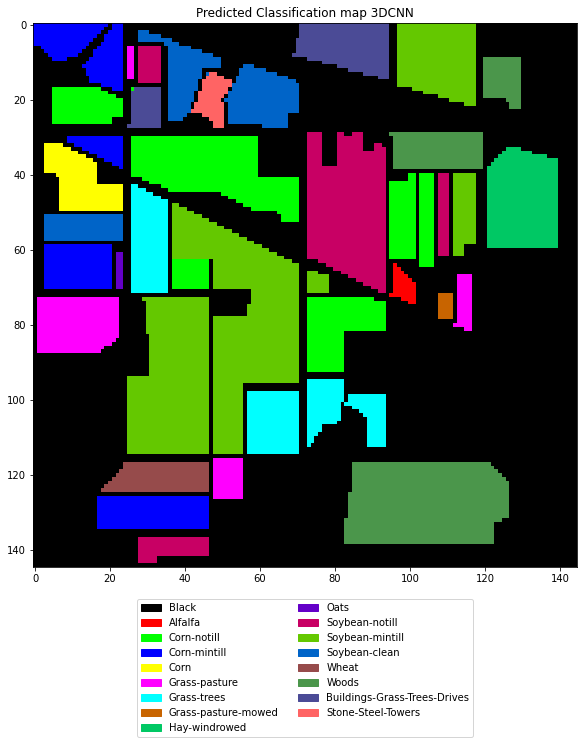

In [40]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,10))
plt.title('Predicted Classification map 3DCNN')
plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

In [41]:
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/3DCNN/predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/3DCNN/ground truth.jpg", y, colors=spectral.spy_colors)

In [42]:
f = open("/content/drive/MyDrive/Colab Notebooks/3DCNN/classification_report.txt", "r")
print(f.read())

0.16202511033043265 Test loss (%)
99.9349594116211 Test accuracy (%)

99.92583863838294 Kappa accuracy (%)
99.9349593495935 Overall accuracy (%)
99.72290640394088 Average accuracy (%)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        14
                 Corn-notill       1.00      1.00      1.00       428
                Corn-mintill       1.00      1.00      1.00       249
                        Corn       1.00      1.00      1.00        71
               Grass-pasture       1.00      1.00      1.00       145
                 Grass-trees       1.00      1.00      1.00       219
         Grass-pasture-mowed       1.00      1.00      1.00         8
               Hay-windrowed       1.00      1.00      1.00       143
                        Oats       1.00      1.00      1.00         6
              Soybean-notill       1.00      1.00      1.00       292
             Soybean-mintill       1.00     

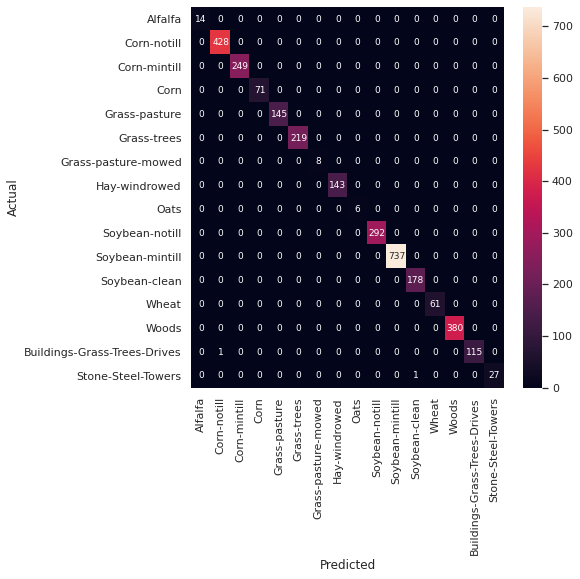

In [43]:
import pandas as pd
import seaborn as sn

names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)


mat = confusion_matrix(np.argmax(ytest, axis=1), y_pred)

df_cm = pd.DataFrame(mat, columns=names, index = names)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}, fmt='d')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/3DCNN/cmap.png', dpi=300)